In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn
import json
import pandas as pd
""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
with open('spotipy_cred.json','r') as f:
    data = json.load(f) 
data

{'SPOTIPY_CLIENT_ID': '6f03a619b5424c0b92f9ce0dcb2841b3',
 'SPOTIPY_CLIENT_SECRET': '088dc108f86c4ae6ba1b3d3960d3fc20'}

In [3]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=data['SPOTIPY_CLIENT_ID'], client_secret=data['SPOTIPY_CLIENT_SECRET'])
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
playlist_link = "https://open.spotify.com/playlist/37i9dQZEVXbNG2KDcFcKOF?si=1333723a6eff4b7f"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [5]:
def get_playlist_info(playlist_id, spot):
    info_list = []
    features_list = []
    
    for track in spot.playlist_tracks(playlist_id)["items"]:
        
         #URI
        track_uri = track["track"]["uri"]

        #Track name
        track_name = track["track"]["name"]

        #Main Artist
        artist_uri = track["track"]["artists"][0]["uri"]
        artist_info = spot.artist(artist_uri)

        #Name, popularity, genre
        artist_name = track["track"]["artists"][0]["name"]
        artist_pop = artist_info["popularity"]
        artist_genres = artist_info["genres"]

        #Album
        album = track["track"]["album"]["name"]

        #Popularity of the track
        track_pop = track["track"]["popularity"]


        info_list.append(
            [track_uri, track_name, artist_uri, artist_info, artist_name, artist_pop, artist_genres, album, track_pop]
        )
        features_list.append(pd.DataFrame(spot.audio_features(track["track"]["uri"])))
        
        
    playlist_df = pd.DataFrame(data = info_list, columns = ['track_uri', 'track_name', 'artist_uri',
                                              'artist_info', 'artist_name', 'artist_pop',
                                              'artist_genres', 'album', 'track_pop'])
    full_music = playlist_df.merge(pd.concat(features_list), left_on = 'track_uri', right_on = 'uri')
    
    return full_music

In [6]:
def genre_list_extractor(genre_series):
    genre_set = set()
    for i in genre_series:
        for gen in i:
            genre_set.add(gen)
    genre_dict = dict()
    for i in genre_set:
         genre_dict[i] = genre_series.apply(lambda x:  1 if i in x else 0)
    return pd.DataFrame(genre_dict)

In [7]:
def get_sum_vector(machine_df):
    trackers = machine_df['track_name']
    vector = machine_df.drop(columns = ['track_name']).sum(axis = 0)
    return np.divide(vector, machine_df.shape[0])

In [8]:
def get_playlist_subsets(playlist_id, spot):
    full_music = get_playlist_info(playlist_id, spot)
    categorical_music = pd.concat([genre_list_extractor(full_music.artist_genres), full_music], axis=1)
    
    #TODO scaling
    typed = categorical_music.dtypes.reset_index()
    catergories = list(typed[typed[0] != 'object']['index'].unique())
    catergories.append('track_name')
    numeric_mus = categorical_music[catergories]
    
    vector = get_sum_vector(numeric_mus)
    
    return categorical_music, numeric_mus, vector

In [9]:
native_fields, machine_fields, vector = get_playlist_subsets(playlist_URI, sp)
machine_fields.head(2)

,reggaeton flow,trap argentino,shimmer pop,deep groove house,house,trap latino,escape room,queens hip hop,canadian contemporary r&b,art pop,urbano espanol,modern rock,drill brasileiro,r&b en espanol,toronto rap,edm,melodic rap,dance pop,trap queen,pop venezolano,art rock,new wave pop,pop rock,r&b,mellow gold,k-pop,dfw rap,gen z singer-songwriter,tropical house,canadian pop,hip hop,rock,piano rock,chill pop,k-pop girl group,baroque pop,colombian pop,modern alternative rock,reggaeton,singer-songwriter,viral pop,minnesota hip hop,indietronica,argentine hip hop,latin,big room,uk dance,pop rap,latin pop,uk pop,afrofuturism,gauze pop,pop,pop dance,canadian hip hop,hip pop,spanish hip hop,electropop,hard rock,post-teen pop,reggaeton colombiano,rap,metal,permanent wave,shiver pop,australian hip hop,glam rock,artist_pop,track_pop,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,100,0.621,0.782,2,-5.548,1,0.0440,0.0125,0.03300,0.230,0.550,128.033,198938,4,"Quevedo: Bzrp Music Sessions, Vol. 52"
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,93,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.00101,0.311,0.662,173.930,167303,4,As It Was


In [22]:
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
import numpy as np

def get_cluster_count(df):
    wcss = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
        kmeans.fit(machine_fields.drop(columns = ['track_name']))
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,11),wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')    
    return plt, wcss

In [11]:
#np.divide(get_sum_vector(machine_fields), 50)
test = get_sum_vector(machine_fields)
#test

C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarn

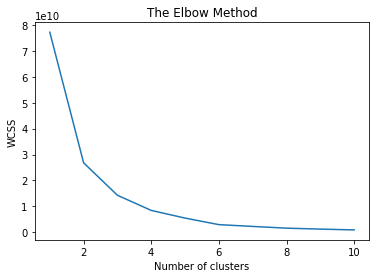

In [48]:
num_clust_plt, wcss= get_cluster_count(machine_fields)
#num_clust_plt.show()

In [46]:
def get_deriv(arr):
    return [((arr[i] - arr[i-1]) / arr[i-1]) for i in range(1, len(arr))]

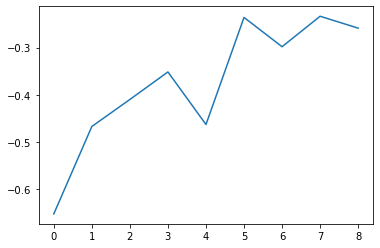

In [49]:
num_clust_plt.plot(range(0, len(wcss) - 1), get_deriv(wcss))
num_clust_plt.show()

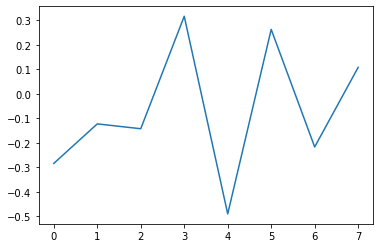

In [50]:
num_clust_plt.plot(range(0, len(wcss) - 2), get_deriv(get_deriv(wcss)))
num_clust_plt.show()

In [39]:
get_deriv(get_deriv(wcss))

[-0.2841814947036544,
 -0.12267677967450895,
 -0.14247268101096855,
 0.31717739704161474,
 -0.49056267433827955,
 0.2634372188019351,
 -0.2169722454942813,
 0.1082947151357625]

In [13]:
def cluster_data(data, n):
    new_df = pd.DataFrame()
    kmeans = KMeans(n_clusters=n, random_state=0)
    new_df['cluster'] = kmeans.fit_predict(data)
    
    centroids = kmeans.cluster_centers_
    
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]
    
    centroids = kmeans.cluster_centers_
    
    x_mapper = dict()
    y_mapper = dict()
    for i in range(0,n):
        x_mapper[i] = cen_x[0]
        y_mapper[i] = cen_y[0]
    
    new_df['cen_x'] = new_df.cluster.apply(lambda x:  x_mapper[x])
    new_df['cen_y'] = new_df.cluster.apply(lambda x:  y_mapper[x])
    
    return new_df, centroids

In [14]:
clus, centers = cluster_data(machine_fields.drop(columns = ['track_name']), 3)

clustered =  pd.concat([machine_fields, clus], axis=1)
clustered.head(2)

C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,reggaeton flow,trap argentino,shimmer pop,deep groove house,house,trap latino,escape room,queens hip hop,canadian contemporary r&b,art pop,urbano espanol,modern rock,drill brasileiro,r&b en espanol,toronto rap,edm,melodic rap,dance pop,trap queen,pop venezolano,art rock,new wave pop,pop rock,r&b,mellow gold,k-pop,dfw rap,gen z singer-songwriter,tropical house,canadian pop,hip hop,rock,piano rock,chill pop,k-pop girl group,baroque pop,colombian pop,modern alternative rock,reggaeton,singer-songwriter,viral pop,minnesota hip hop,indietronica,argentine hip hop,latin,big room,uk dance,pop rap,latin pop,uk pop,afrofuturism,gauze pop,pop,pop dance,canadian hip hop,hip pop,spanish hip hop,electropop,hard rock,post-teen pop,reggaeton colombiano,rap,metal,permanent wave,shiver pop,australian hip hop,glam rock,artist_pop,track_pop,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name,cluster,cen_x,cen_y
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,100,0.621,0.782,2,-5.548,1,0.0440,0.0125,0.03300,0.230,0.550,128.033,198938,4,"Quevedo: Bzrp Music Sessions, Vol. 52",2,0.083333,3.469447e-18
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,93,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.00101,0.311,0.662,173.930,167303,4,As It Was,0,0.083333,3.469447e-18


In [15]:
temp = pd.DataFrame(centers).describe().T
temp['relative'] = temp['std'] / (temp['max'] - temp['min'])
temp[(temp.relative < 0.57) & (temp.relative > 0.50 )]

,count,mean,std,min,25%,50%,75%,max,relative
5,3.0,0.257937,0.095486,1.666667e-01,0.208333,0.250000,0.303571,0.357143,0.501300
8,3.0,0.037698,0.035879,6.938894e-18,0.020833,0.041667,0.056548,0.071429,0.502309
11,3.0,0.051587,0.045071,-6.938894e-18,0.035714,0.071429,0.077381,0.083333,0.540848
17,3.0,0.138889,0.127294,2.775558e-17,0.083333,0.166667,0.208333,0.250000,0.509175
29,3.0,0.089286,0.050857,4.166667e-02,0.062500,0.083333,0.113095,0.142857,0.502588
38,3.0,0.257937,0.095486,1.666667e-01,0.208333,0.250000,0.303571,0.357143,0.501300
40,3.0,0.051587,0.045071,-6.938894e-18,0.035714,0.071429,0.077381,0.083333,0.540848
44,3.0,0.244048,0.142981,8.333333e-02,0.187500,0.291667,0.324405,0.357143,0.522192
52,3.0,0.359127,0.066904,2.857143e-01,0.330357,0.375000,0.395833,0.416667,0.510900
61,3.0,0.051587,0.045071,-1.387779e-17,0.035714,0.071429,0.077381,0.083333,0.540848


In [16]:


#colors = ['#DF2020', '#81DF20', '#2095DF']
colors = ['r', 'g', 'b', 'o', 'i']
clustered['c'] = clustered.cluster.apply(lambda x: colors[x])
clustered.head(2)

,reggaeton flow,trap argentino,shimmer pop,deep groove house,house,trap latino,escape room,queens hip hop,canadian contemporary r&b,art pop,urbano espanol,modern rock,drill brasileiro,r&b en espanol,toronto rap,edm,melodic rap,dance pop,trap queen,pop venezolano,art rock,new wave pop,pop rock,r&b,mellow gold,k-pop,dfw rap,gen z singer-songwriter,tropical house,canadian pop,hip hop,rock,piano rock,chill pop,k-pop girl group,baroque pop,colombian pop,modern alternative rock,reggaeton,singer-songwriter,viral pop,minnesota hip hop,indietronica,argentine hip hop,latin,big room,uk dance,pop rap,latin pop,uk pop,afrofuturism,gauze pop,pop,pop dance,canadian hip hop,hip pop,spanish hip hop,electropop,hard rock,post-teen pop,reggaeton colombiano,rap,metal,permanent wave,shiver pop,australian hip hop,glam rock,artist_pop,track_pop,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name,cluster,cen_x,cen_y,c
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,100,0.621,0.782,2,-5.548,1,0.0440,0.0125,0.03300,0.230,0.550,128.033,198938,4,"Quevedo: Bzrp Music Sessions, Vol. 52",2,0.083333,3.469447e-18,b
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,93,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.00101,0.311,0.662,173.930,167303,4,As It Was,0,0.083333,3.469447e-18,r


In [17]:
def plot_axis_cluster(clust, cent, cat1, cat2):
    divisor = 4
    
    plt.scatter(clust[cat1], clust[cat2], c = clust.c, alpha = 0.6, s=10)
    num1 = clust.columns.get_loc(cat1)
    num2 = clust.columns.get_loc(cat2)
    for i in range(0,len(cent)):
        plt.plot(cent[i][num1], cent[i][num2], 'v', c = 'black')
        #print(i[num1], i[num2])
        
    for i, row in clustered.iterrows():
        if i % divisor == 0:
            plt.text(row[cat1], row[cat2], row.track_name)
            
    plt.xlabel(cat1)
    plt.ylabel(cat2)
    
    return plt
    
    

In [18]:
clustered

,reggaeton flow,trap argentino,shimmer pop,deep groove house,house,trap latino,escape room,queens hip hop,canadian contemporary r&b,art pop,urbano espanol,modern rock,drill brasileiro,r&b en espanol,toronto rap,edm,melodic rap,dance pop,trap queen,pop venezolano,art rock,new wave pop,pop rock,r&b,mellow gold,k-pop,dfw rap,gen z singer-songwriter,tropical house,canadian pop,hip hop,rock,piano rock,chill pop,k-pop girl group,baroque pop,colombian pop,modern alternative rock,reggaeton,singer-songwriter,viral pop,minnesota hip hop,indietronica,argentine hip hop,latin,big room,uk dance,pop rap,latin pop,uk pop,afrofuturism,gauze pop,pop,pop dance,canadian hip hop,hip pop,spanish hip hop,electropop,hard rock,post-teen pop,reggaeton colombiano,rap,metal,permanent wave,shiver pop,australian hip hop,glam rock,artist_pop,track_pop,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name,cluster,cen_x,cen_y,c
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,100,0.621,0.782,2,-5.548,1,0.0440,0.012500,0.033000,0.2300,0.550,128.033,198938,4,"Quevedo: Bzrp Music Sessions, Vol. 52",2,0.083333,3.469447e-18,b
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,93,0.520,0.731,6,-5.338,0,0.0557,0.342000,0.001010,0.3110,0.662,173.930,167303,4,As It Was,0,0.083333,3.469447e-18,r
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,98,0.911,0.712,1,-5.105,0,0.0817,0.090100,0.000027,0.0933,0.425,92.005,178567,4,Me Porto Bonito,2,0.083333,3.469447e-18,b
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,91,0.798,0.697,0,-7.139,1,0.0891,0.020200,0.000000,0.2590,0.745,90.031,186964,4,Pink Venom,2,0.083333,3.469447e-18,b
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,97,0.650,0.715,5,-5.198,0,0.2530,0.099300,0.000291,0.1260,0.187,106.672,243717,4,Tití Me Preguntó,1,0.083333,3.469447e-18,g
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,96,0.919,0.623,7,-6.521,1,0.0992,0.184000,0.000016,0.0609,0.775,130.037,157018,4,DESPECHÁ,0,0.083333,3.469447e-18,r
6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,83,95,0.835,0.679,7,-5.329,0,0.0364,0.583000,0.000002,0.2180,0.850,124.980,162638,4,La Bachata,0,0.083333,3.469447e-18,r
7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,96,0.801,0.475,7,-8.797,0,0.0516,0.141000,0.000017,0.0639,0.234,98.047,213061,4,Efecto,2,0.083333,3.469447e-18,b
8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,80,93,0.629,0.547,10,-13.123,0,0.0550,0.720000,0.003140,0.0604,0.197,108.375,298933,4,Running Up That Hill (A Deal With God),1,0.083333,3.469447e-18,g
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,94,0.704,0.797,0,-5.927,1,0.0475,0.082600,0.000745,0.0546,0.825,139.994,148486,4,I Ain't Worried,0,0.083333,3.469447e-18,r


<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

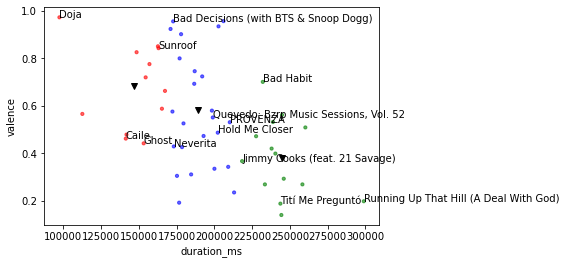

In [19]:
plter = plot_axis_cluster(clustered, centers, 'duration_ms', 'valence')
plter

<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

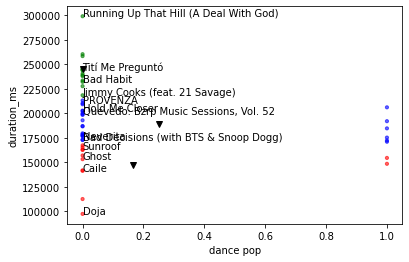

In [20]:
plter = plot_axis_cluster(clustered, centers, 'dance pop', 'duration_ms')
plter

<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

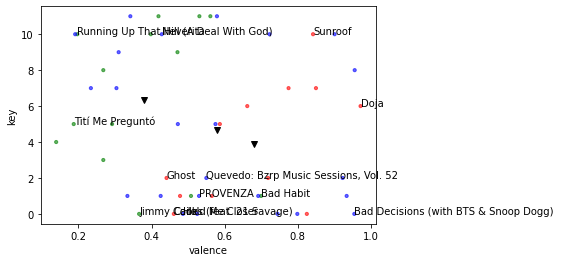

In [21]:
plter = plot_axis_cluster(clustered, centers, 'valence', 'key')
plter